In [1]:
%run PSO.ipynb #da qui possiamousare la funzione PSO

In [1]:
import keras
import numpy as np
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from keras.optimizers import SGD, Adam, RMSprop
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

## **Dataset**
This is a collection of documents that appeared on Reuters newswire in 1987. The documents were assembled and indexed with categories. Each newswire is encoded as a list of word indexes (integers). 

For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

The mean number of words per document, grouped by class, is between 93 and 1263 on the training set.

Reuters is a multi-class (e.g. there are multiple classes), multi-label (e.g. each document can belong to many classes) dataset.

In this code we use a reduced version of the original dataset with 8982 training istances and 2246 testing istances and 46 classes (the original dataset has 90 classes).


In [15]:
# Let's load the data

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)


In [3]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

8982 train sequences
2246 test sequences


In [4]:
print('This is an example of train input istance: ', x_train[0])
print('This is an example of target istance: ', y_train[0])

This is an example of train input istance:  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
This is an example of target istance:  3


The number of documents' words are:  [87, 56, 139, 224, 101, 116, 100, 100, 82, 106, 31, 59, 65, 316, 527, 76, 114, 17, 91, 77, 231, 108, 83, 29, 95, 110, 23, 373, 114, 354, 133, 222, 571, 155, 83, 208, 170, 269, 74, 19, 23, 78, 21, 377, 104, 299, 89, 56, 94, 139, 118, 36, 137, 107, 83, 66, 70, 112, 88, 51, 83, 123, 17, 185, 84, 52, 102, 73, 106, 486, 107, 82, 263, 172, 491, 190, 143, 62, 26, 88, 114, 38, 85, 112, 793, 104, 25, 21, 101, 28, 25, 81, 135, 73, 62, 18, 90, 266, 91, 64, 409, 92, 319, 166, 85, 200, 152, 474, 60, 58, 584, 71, 273, 51, 255, 28, 171, 143, 91, 46, 110, 77, 162, 24, 52, 175, 61, 95, 97, 259, 112, 73, 94, 17, 650, 23, 88, 309, 105, 89, 41, 314, 54, 374, 67, 160, 75, 207, 373, 84, 87, 74, 98, 136, 256, 95, 50, 108, 52, 100, 233, 86, 68, 47, 73, 158, 113, 23, 100, 80, 202, 104, 122, 101, 95, 118, 253, 192, 80, 183, 29, 604, 41, 103, 63, 147, 472, 58, 23, 37, 98, 73, 122, 812, 51, 179, 56, 60, 60, 25, 212, 34, 406, 122, 27, 86, 83, 43, 208, 26, 159, 65, 48, 335, 701,

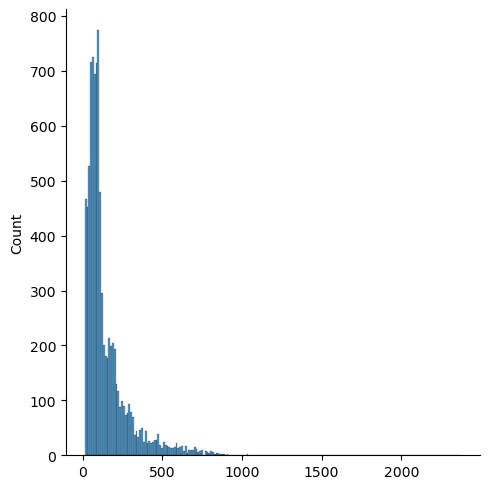

In [23]:
# Let's see which is number of word for document
doc_len = []
for document in x_train:
    doc_len.append(len(document))

print("The number of documents' words are: ", doc_len)
print("The MINIMUM number of words for a document is : ", min(doc_len), '\n The MAXIMUM number of words for a document is : ', max(doc_len), '\n the MEAN number of world for each document is: ', round(sum(doc_len)/len(doc_len),2))

# We want to see the distribution of the document length
sns.displot(doc_len)


46 classes


<BarContainer object of 46 artists>

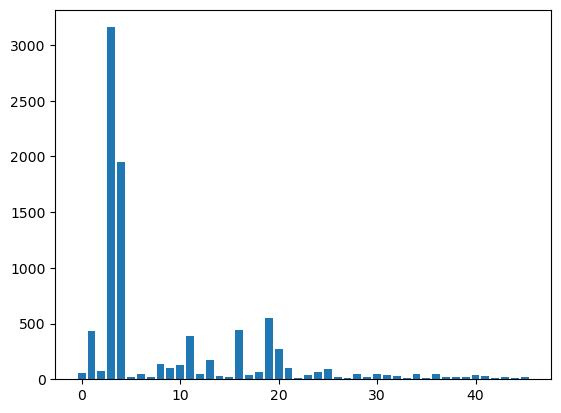

In [5]:
from collections import Counter

# let's see the number of classes of the target variable
num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

# And let's show their frequency in the training dataset

plt.bar(sorted(Counter(y_train)), [Counter(y_train)[i] for i in sorted(Counter(y_train))])

### **Preparing data**

In [13]:
print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=10000) # This class allows to vectorize a text corpus, by turning each text into a sequence of integers (each integer being the index of a token in a dictionary)

x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


Vectorizing sequence data...
x_train shape: (8982, 10000)
x_test shape: (2246, 10000)


In [14]:
# We convert the categorical variable in one-hot encode.

print('Convert class vector to binary class matrix for use with categorical_crossentropy')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('Eexample of y_train istance: ', y_train[0])

Convert class vector to binary class matrix for use with categorical_crossentropy
y_train shape: (8982, 46)
y_test shape: (2246, 46)
example of y_train istance:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## **Multi-layer Perceptron**

In [8]:
from keras.callbacks import EarlyStopping

def MLP(particle_position):
    '''This function returns the accuracy of a neural network model with the parameter set as the component of the particle position.
     The first component of the position will be the batch size, the second willl be the optimizer and the third will be the learning rate. 
     particle_position[0]: batch_size
     particle_position[1]: optimizer (<1: SGD; within [1,2): SGD with Momentum; within [2,3): Adam; within [3,inf]: RMSPROP )
     particle_position[2]: learning_rate'''
    
    batch_s = particle_position[0]
    batch_s = int(batch_s)
    optimiz = particle_position[1]
    lr = particle_position[2]
    num_neuron = particle_position[3]
    
    model = Sequential()
    model.add(Dense(int(num_neuron), input_shape=(10000,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    early_stopping = EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=3, verbose=0, mode='max', baseline=0.97)
    callbacks = [early_stopping]

    if optimiz < 1:
        #use SGD
        opt = SGD(learning_rate = lr)
        
    elif optimiz >=1 and optimiz < 2:
        #use SGD with Momentum
        opt = SGD(momentum = 0.9, learning_rate = lr)

    elif optimiz >= 2 and optimiz < 3:
        #use ADAM
        opt = Adam(learning_rate = lr)

    else:
        #use RMSPROP
        opt = RMSprop(learning_rate = lr)

    model.compile(optimizer= opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=batch_s,
                    validation_split=0.2,
                    callbacks=callbacks, 
                    verbose = 0)
    
    last_accuracy = history.history['val_accuracy'][-1]

    return last_accuracy

We use a swarm with 10 particles of dimension 4. The first dimension is the batch size, the seocnd is the type of optimizer (it can be 4 possible type), the third dimension is the learning rate and the fourth dimension is the number of neurons for the inner layer.

In [9]:
best_positions, evaluation, best_parameter, best_accuracy = PSO(swarm_size = 10,
                                    dim = 4,
                                    evaluation_funct = MLP,
                                    lower_bound=[10,0,0.001, 90],
                                    upper_bound = [128,4,0.1, 600],
                                    v_max = [64,2,0.001, 200],
                                    problem = 'maximum',
                                    max_iteration = 20,
                                    termination_criteria = ['fixed_iteration', 'swarm_radius'],
                                    max_tol = 0.1)

print('Best position found: ', best_parameter, 'with an accuracy of: ',best_accuracy)

Starting swarm position:  [array([5.65469038e+01, 1.17138898e+00, 1.90743602e-02, 5.41095532e+02]), array([6.94343340e+01, 9.45964972e-01, 7.24719441e-02, 4.67188309e+02]), array([3.37235313e+01, 8.27002934e-01, 2.03053193e-02, 3.16818618e+02]), array([6.33384674e+01, 2.47225698e+00, 9.49493949e-02, 1.06814019e+02]), array([4.42606022e+01, 5.82076826e-01, 7.79809920e-02, 9.32079119e+01]), array([5.13717953e+01, 2.74149541e+00, 8.91390492e-02, 5.61950256e+02]), array([9.44826591e+01, 2.61606773e-01, 1.20883593e-03, 1.41849361e+02]), array([8.34043848e+01, 2.68942957e+00, 2.93625953e-02, 2.36681872e+02]), array([1.87672797e+01, 5.05921378e-01, 7.72584871e-02, 1.99463944e+02]), array([1.19822130e+02, 3.38847035e+00, 8.29725124e-02, 2.69002726e+02])] 
 with an evaluation of:  [0.8069003820419312]
Iteration  0
Swarm position:  [array([5.65469038e+01, 1.17138898e+00, 1.90743602e-02, 5.41095532e+02]), array([6.29919191e+01, 1.01065518e+00, 4.79576485e-02, 4.90310989e+02]), array([4.44482360e+

In [10]:
evaluation

[0.8069003820419312,
 0.8096827864646912,
 0.8096827864646912,
 0.813021719455719,
 0.8196995258331299,
 0.8196995258331299,
 0.8196995258331299,
 0.8196995258331299,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221,
 0.8219254016876221]

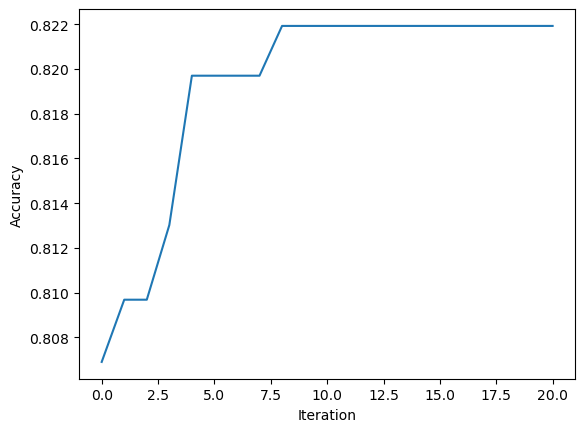

In [11]:
# Let's plot the best evaluation function (in this case the best accuracy) found for each iteration.
plt.plot(list(range(len(evaluation))), evaluation)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

Text(0.5, 1.0, 'Neuron number')

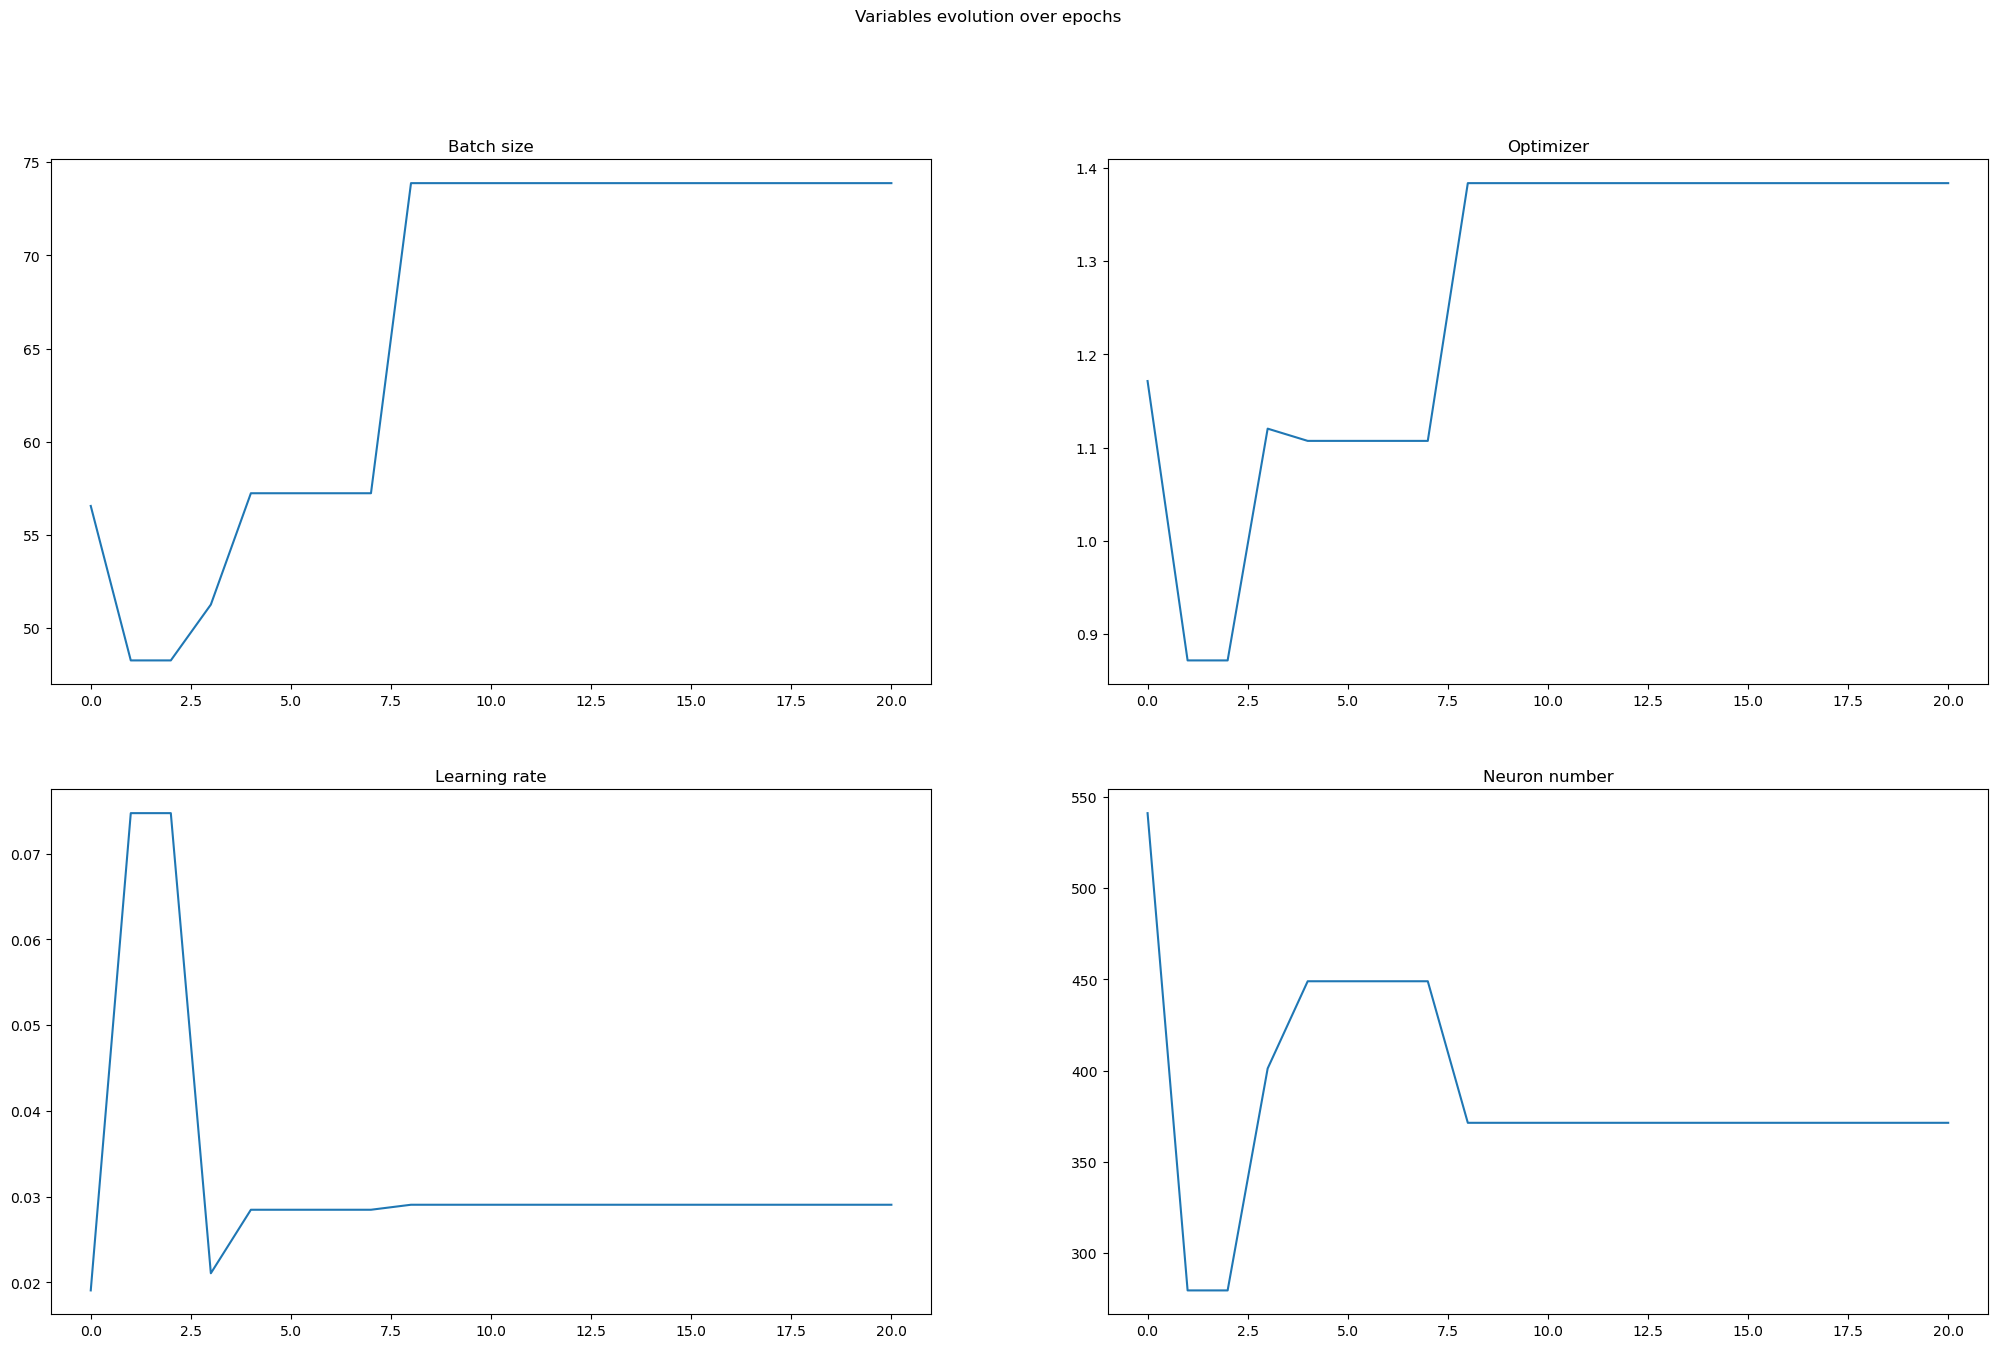

In [12]:
batch_size = [iter[0] for iter in best_positions]
optimizer = [iter[1] for iter in best_positions]
learning_rate = [iter[2] for iter in best_positions]
num_neuron = [iter[3] for iter in best_positions]

n_iteration = len(batch_size)


variable = [batch_size, optimizer, learning_rate, num_neuron]
variable_name = ['batch_size','optimizer','learning_rate','num_neuron']

fig, axes = plt.subplots(2, 2, figsize=(25, 15))
fig.suptitle('Variables evolution over epochs')

axes[0,0].plot(list(range(n_iteration)), batch_size)
axes[0,0].set_title('Batch size')

axes[0,1].plot(list(range(n_iteration)), optimizer)
axes[0,1].set_title('Optimizer')

axes[1,0].plot(list(range(n_iteration)), learning_rate)
axes[1,0].set_title('Learning rate')

axes[1,1].plot(list(range(n_iteration)), num_neuron)
axes[1,1].set_title('Neuron number')


